In [1]:
!wget https://github.com/DeepQuestAI/Fire-Smoke-Dataset/releases/download/v1/FIRE-SMOKE-DATASET.zip
!unzip FIRE-SMOKE-DATASET.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!pip3 install torchfusion_utils

In [3]:

from PIL import Image


In [4]:
from torchfusion_utils.fp16 import convertToFP16
from torchfusion_utils.initializers import *
from torchfusion_utils.metrics import Accuracy
from torchfusion_utils.models import load_model,save_model

In [5]:
import time
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [6]:
transforms_train = transforms.Compose([transforms.Resize(225),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])

transforms_test = transforms.Compose([transforms.Resize(225),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])

batch_sizes = 64
test = './test'
train = './train'

train_data = datasets.ImageFolder(root=train, transform=transforms_train)
test_data = datasets.ImageFolder(root=test, transform=transforms_test)

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sizes, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_sizes, shuffle=True)

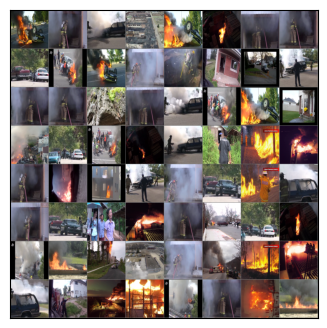

In [7]:
images, labels = next(iter(train_data_loader))

def image_display(image, title=None):
    image = image/2 + 0.5
    numpy_image = image.numpy()
    transposed_numpy_image = np.transpose(numpy_image, (1, 2, 0))
    plt.figure(figsize=(20, 4))
    plt.imshow(transposed_numpy_image)
    plt.yticks([])
    plt.xticks([])
    if title:
        plt.title(title)
    plt.show
    
image_display(torchvision.utils.make_grid(images))

In [8]:
ResNet = models.resnet50(num_classes=3)

In [9]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:

Model = ResNet 
Model = Model.to(device)
lr = 0.001
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Model.parameters(), lr=lr)
Model,optimizer = convertToFP16(Model, optimizer)
milestones = [100, 150]
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)

In [11]:
def model_traing_and_validation_loop(Model, n_epochs, save_path):
    
    n_epochs = n_epochs
    saving_criteria_of_model = 0
    training_loss_array = []
    validation_loss_array = []
    train_acc = Accuracy()
    validation_acc = Accuracy(topK=1)

    for i in range(n_epochs):

        total_test_data = 0
        total_train_data = 0
        correct_test_data = 0
        training_loss = 0
        validation_loss = 0
        train_acc.reset()

        for data, target in train_data_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            predictions = Model(data)
            loss = criteria(predictions, target)
            optimizer.backward(loss)
            optimizer.step()
            training_loss += loss.item()*data.size(0)
            train_acc.update(predictions, target)
            
        scheduler.step()

        with torch.no_grad():
            
            validation_acc.reset()
            
            for data, target in test_data_loader:

                data, target = data.to(device), target.to(device)
                predictions = Model(data)
                loss = criteria(predictions, target)
                validation_acc.update(predictions, target)
                total_test_data += target.size(0)
                validation_loss += loss.item()*data.size(0)
                
                
        training_loss = training_loss / len(train_data)
        validation_loss = validation_loss / total_test_data
        training_loss_array.append(training_loss)
        validation_loss_array.append(validation_loss)


        print(f'{i+1} / {n_epochs} Training loss: {training_loss}, Tran_Accuracy: {train_acc.getValue()}, Validation_loss: {validation_loss}, Validation_Accuracy: {validation_acc.getValue()}')

        if saving_criteria_of_model < validation_acc.getValue():

            torch.save(Model, save_path)
            
            saving_criteria_of_model = validation_acc.getValue()
            
            print('--------------------------Saving Model---------------------------')
         
        
    plt.figure(figsize=(20, 4))
        
    x_axis = (range(n_epochs))
        
    plt.plot(x_axis, training_loss_array, 'r', validation_loss_array, 'b')
        
    plt.title('A gragh of training loss vs validation loss')
        
    plt.legend(['train loss', 'validation loss'])
        
    plt.xlabel('Number of Epochs')
        
    plt.ylabel('Loss')
        
    return Model


1 / 5 Training loss: 1.0500037924757282, Tran_Accuracy: 0.11407767236232758, Validation_loss: 1.0440234375, Validation_Accuracy: 0.10000000149011612
--------------------------Saving Model---------------------------
2 / 5 Training loss: 1.0529429611650485, Tran_Accuracy: 0.10679611563682556, Validation_loss: 1.0515625, Validation_Accuracy: 0.07000000029802322
3 / 5 Training loss: 0.6745831943252711, Tran_Accuracy: 0.45145630836486816, Validation_loss: 0.0004176902770996094, Validation_Accuracy: 1.0
--------------------------Saving Model---------------------------
4 / 5 Training loss: 0.00018208061607138625, Tran_Accuracy: 1.0, Validation_loss: 2.2673606872558593e-06, Validation_Accuracy: 1.0
5 / 5 Training loss: 3.4437596219257243e-06, Tran_Accuracy: 1.0, Validation_loss: 1.4066696166992187e-07, Validation_Accuracy: 1.0


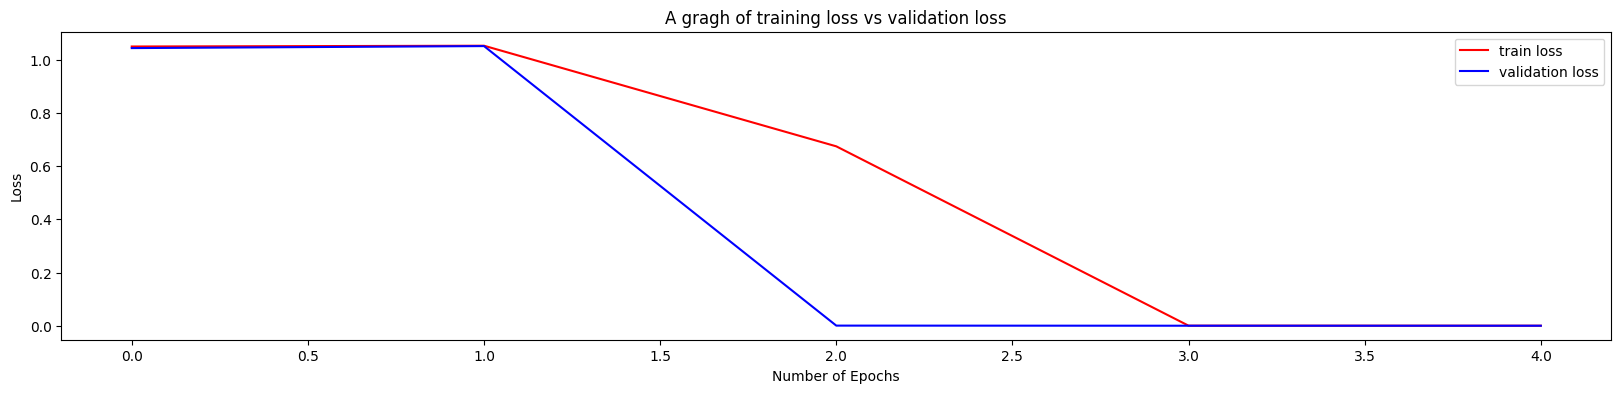

In [12]:
#Uncomment to retrain the model
n_epochs = 5
model = model_traing_and_validation_loop(Model, n_epochs, 'fire-flame.pt')

In [13]:
!wget https://github.com/DeepQuestAI/Fire-Smoke-Dataset/releases/download/v1/fire-flame.pt

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [14]:
load_saved_model = torch.load('./fire-flame.pt')

In [15]:
dummy_input = torch.FloatTensor(1,3,224,224)
dummy_input = dummy_input.to(device)

In [16]:

#torch.onnx.export(load_saved_model, dummy_input, 'fire-flame.onnx')

In [17]:
!wget https://github.com/DeepQuestAI/Fire-Smoke-Dataset/releases/download/v1/fire-smoke-neutral-inference-images.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [18]:
!unzip ./fire-smoke-neutral-inference-images.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [19]:
img_path = './tempDir/cubaan.jpg'

In [20]:
def inferenceing_function(img_path):
    
    def image_display(img_path):
        
        plt.figure(figsize=(30, 6))
        plt.imshow(Image.open(img_path))
        plt.yticks([])
        plt.xticks([])
        
        plt.show()
        return 'Image of: fire'
    
    def model_inference_results():

        transformer = transforms.Compose([transforms.Resize(225),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5, 0.5, 0.5],
                                                          [0.5, 0.5, 0.5])])
        img = Image.open(img_path)
        img_processed = transformer(img).unsqueeze(0)
        img_var = Variable(img_processed, requires_grad= False)
        img_var = img_var.cuda()
        load_saved_model.eval()
        logp = load_saved_model(img_var)
        expp = torch.softmax(logp, dim=1)
        confidence, clas = expp.topk(1, dim=1) 

        print(img_var.shape)  # Print the shape of img_var tensor
        print(logp.shape)     # Print the shape of logp tensor
        
        return '',f'Confidence score: {confidence.item()}'
        
    
    
    return (image_display(img_path), *model_inference_results())

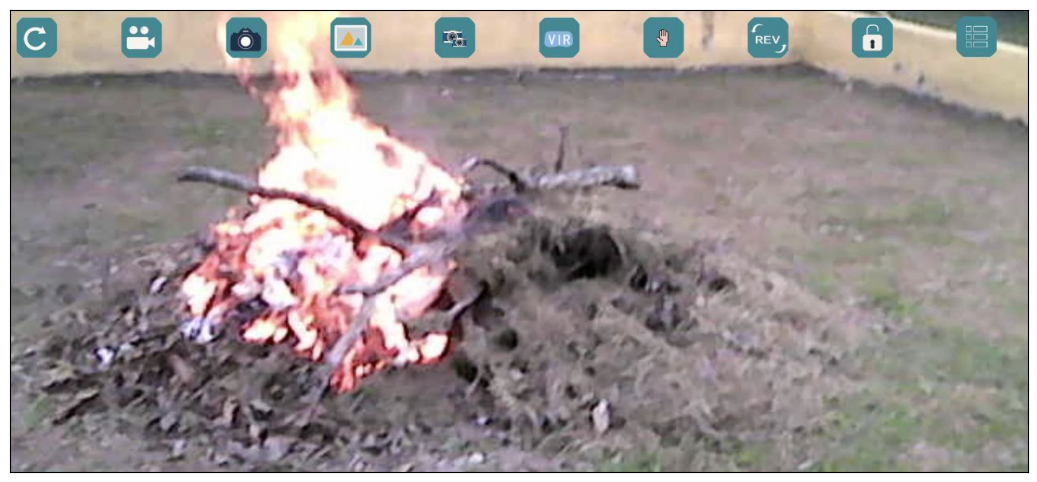

torch.Size([1, 3, 224, 224])
torch.Size([1, 3])


('Image of: fire', '', 'Confidence score: 1.0')

In [21]:
inferenceing_function(img_path)